### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb



In [3]:
df_lagged = pd.read_csv(r'E:\Nieuw dataset\Timeseriessplit\evsales_trends_lagged_sales2_google0.csv')

### Time series split

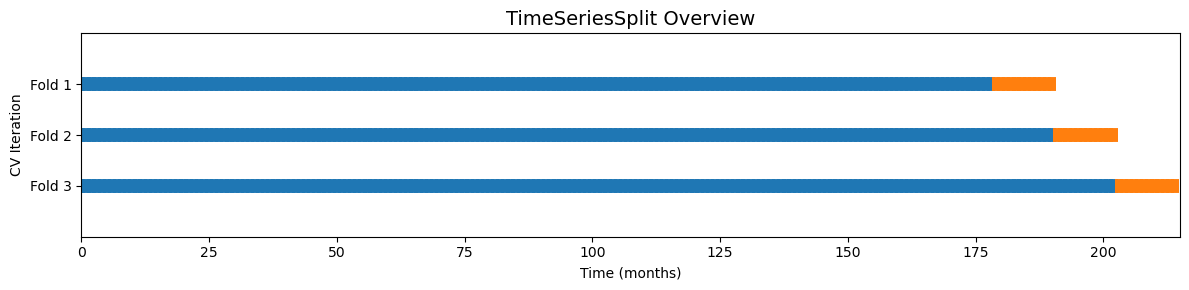

In [5]:
# --- Load your data ---
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)
X = df.drop(columns=['Totaal_verkochte_wegvoertuigen', 'Periode'])
y = df['Totaal_verkochte_wegvoertuigen']

# --- Define TimeSeriesSplit ---
n_splits = 3
test_size = 12
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# --- Custom color map for CV ---
cmap_cv = mcolors.ListedColormap(["#1f77b4", "#ff7f0e"])  # Blue for train, Orange for test

# --- Plot function ---
def plot_cv_indices(cv, X, y, ax, lw=10):
    for ii, (train_index, test_index) in enumerate(cv.split(X=X)):
        indices = np.full(len(X), np.nan)
        indices[train_index] = 0
        indices[test_index] = 1

        ax.scatter(
            range(len(X)),
            [ii + 0.5] * len(X),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=[f"Fold {i+1}" for i in range(n_splits)],
        xlabel="Time (months)",
        ylabel="CV Iteration",
        ylim=[n_splits + 0.5, -0.5],
        xlim=[0, len(X)],
    )
    ax.set_title("TimeSeriesSplit Overview", fontsize=14)

# --- Run and plot ---
fig, ax = plt.subplots(figsize=(12, 3))
plot_cv_indices(tscv, X, y, ax)
plt.tight_layout()
plt.show()


### Model 1 (Arima) 

ARIMA is a widely used model for time series analysis. It is a statistical model that uses past values to predict future values of a time series. ARIMA models are widely used in fields like finance, economics, and meteorology. The model works well when the data has a clear trend, seasonality, and is stationary.

https://medium.com/@yennhi95zz/a-guide-to-time-series-models-in-machine-learning-usage-pros-and-cons-ac590a75e8b3 


Fold 1
Train: 2007-03-01 to 2022-01-01
Validation: 2022-02-01 to 2022-04-01
RMSE: 2984.93
MAE: 2340.65
MAPE / Error margin (%): 17.27


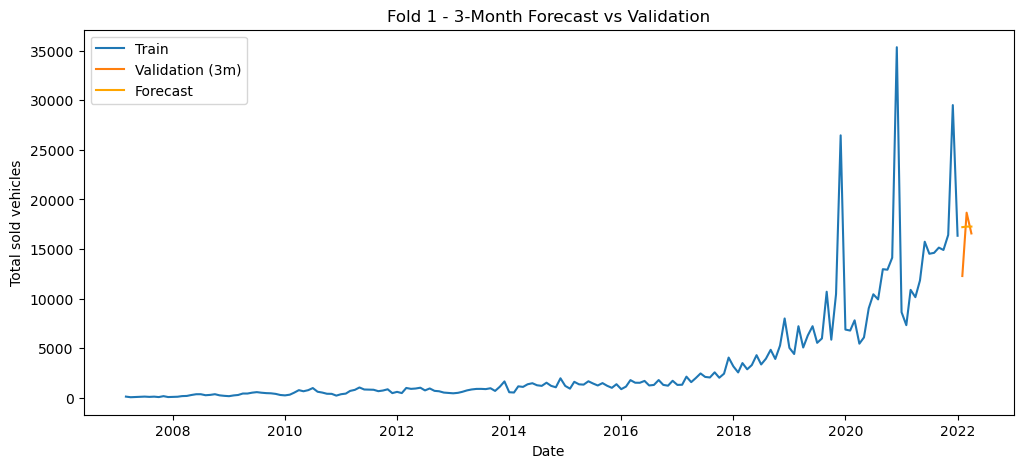


Fold 2
Train: 2007-03-01 to 2023-01-01
Validation: 2023-02-01 to 2023-04-01
RMSE: 4162.09
MAE: 2917.66
MAPE / Error margin (%): 12.85


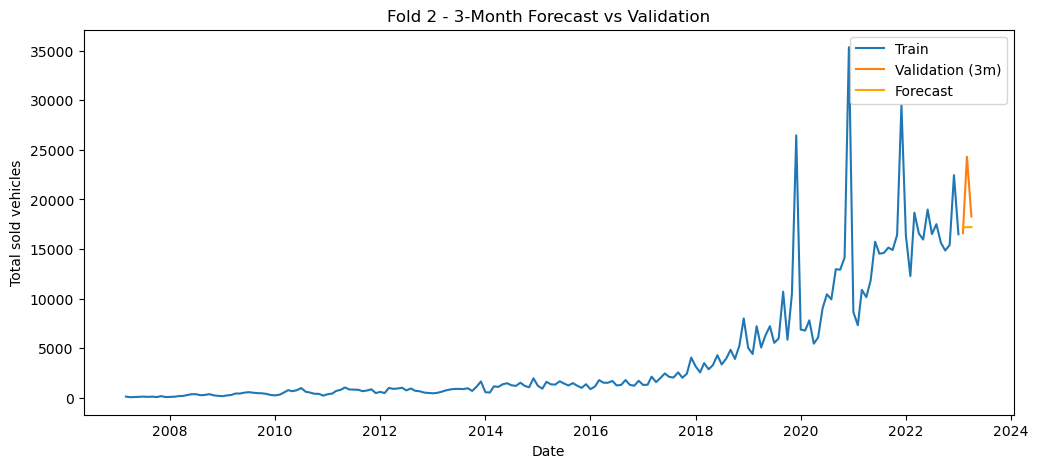


Fold 3
Train: 2007-03-01 to 2024-01-01
Validation: 2024-02-01 to 2024-04-01
RMSE: 3468.77
MAE: 2946.26
MAPE / Error margin (%): 10.99


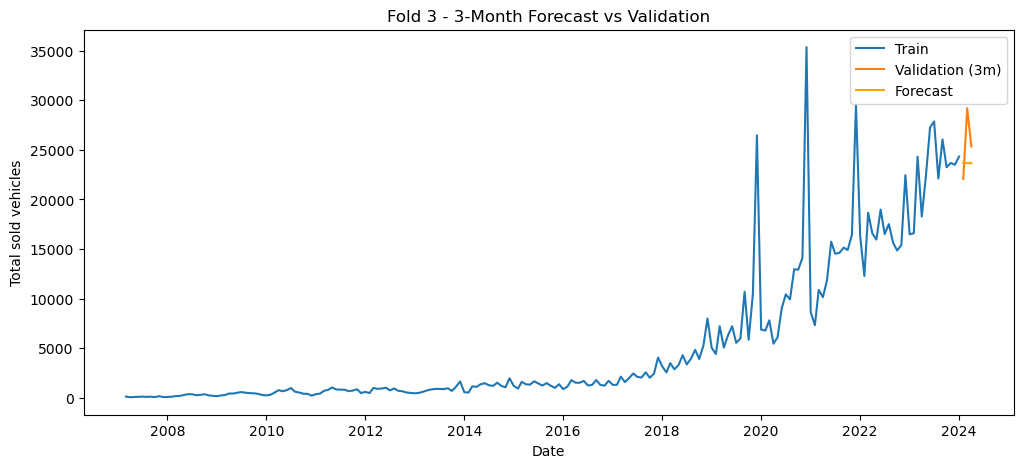


 Average performance over all folds:
Average RMSE: 3538.60
Average MAE: 2734.86
Average MAPE / Error margin (%): 13.70


In [6]:
# Load data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Target only
y = df['Totaal_verkochte_wegvoertuigen']
forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Metrics storage
rmse_scores, mae_scores, mape_scores = [], [], []

for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    y_val = y_val_full.iloc[:forecast_horizon]

    # Fit ARIMA model
    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100  # In percentage

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    print(f"\nFold {i+1}")
    print(f"Train: {df.iloc[train_index]['Periode'].min().date()} to {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation: {df.iloc[val_index]['Periode'].min().date()} to {(df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1)).date()}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Error margin (%): {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation (3m)')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - 3-Month Forecast vs Validation')
    plt.xlabel('Date')
    plt.ylabel('Total sold vehicles')
    plt.legend()
    plt.show()

# Print averages
print("\n Average performance over all folds:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE / Error margin (%): {np.mean(mape_scores):.2f}")


Arima doesnt use feature importance so sarima was used 


 Evaluating WITHOUT feature: thuis opladen

 Evaluating WITHOUT feature: elektrische auto

 Evaluating WITHOUT feature: hybride elektrisch

 Evaluating WITHOUT feature: Bijtellingspercentage


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dylan\anaconda3\Lib\s


 Evaluating WITHOUT feature: Consumentenvertrouwen


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 Evaluating WITHOUT feature: Economisch klimaat

 Evaluating WITHOUT feature: Koopbereidheid

 Evaluating WITHOUT feature: Grote aankopen

 Evaluating WITHOUT feature: BenzineEuro95_1_first

 Evaluating WITHOUT feature: BenzineEuro95_1_last

 Evaluating WITHOUT feature: BenzineEuro95_1_min

 Evaluating WITHOUT feature: BenzineEuro95_1_max

 Evaluating WITHOUT feature: BenzineEuro95_1_mean

 Evaluating WITHOUT feature: Diesel_2_first

 Evaluating WITHOUT feature: Diesel_2_last

 Evaluating WITHOUT feature: Diesel_2_min

 Evaluating WITHOUT feature: Diesel_2_max

 Evaluating WITHOUT feature: Diesel_2_mean

 Evaluating WITHOUT feature: Totaal_verkochte_wegvoertuigen_lag1

 Evaluating WITHOUT feature: Totaal_verkochte_wegvoertuigen_lag2


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 LOFO results (sorted by lowest RMSE):
                       Feature_left_out     Avg_RMSE      Avg_MAE  \
6                        Koopbereidheid  2212.410098  1782.601994   
18  Totaal_verkochte_wegvoertuigen_lag1  2422.869411  1860.193445   
19  Totaal_verkochte_wegvoertuigen_lag2  2620.498882  1922.657036   
1                      elektrische auto  2709.613392  2398.223795   
14                        Diesel_2_last  2887.673349  2369.606404   
15                         Diesel_2_min  2895.408285  2428.803252   
2                    hybride elektrisch  2898.826036  2361.000213   
11                  BenzineEuro95_1_max  2903.630158  2364.394288   
16                         Diesel_2_max  2905.810095  2377.342522   
13                       Diesel_2_first  2914.720548  2453.577635   
17                        Diesel_2_mean  2952.907018  2456.043105   
0                         thuis opladen  2989.429932  2489.145604   
7                        Grote aankopen  3028.756825  2490.7125

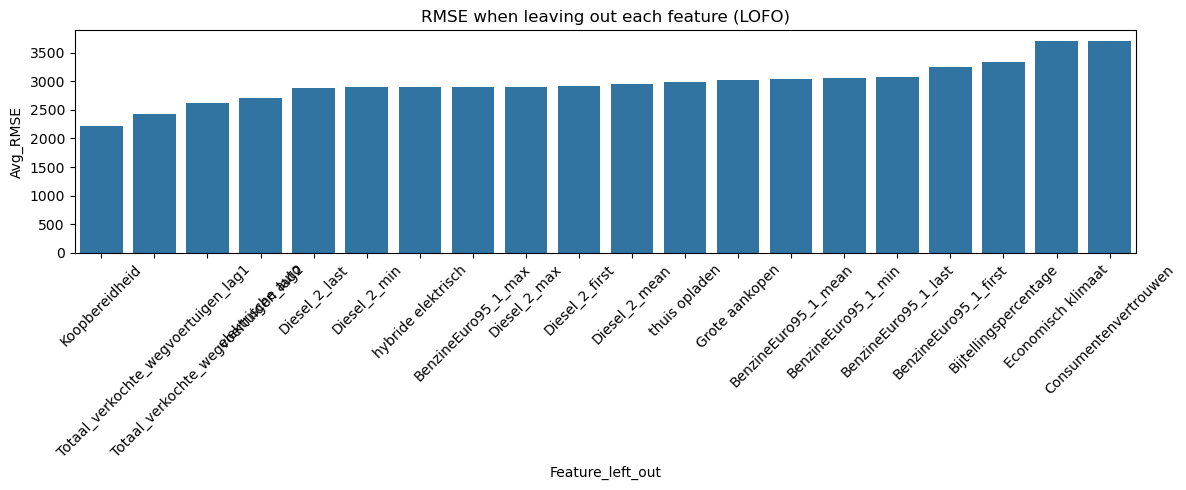

In [ ]:
# Prepare data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

target_column = 'Totaal_verkochte_wegvoertuigen'
all_feature_columns = [col for col in df.columns if col not in ['Periode', target_column]]

forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

results = []

for feature_to_leave_out in all_feature_columns:
    print(f"\n Evaluating WITHOUT feature: {feature_to_leave_out}")
    feature_columns = [col for col in all_feature_columns if col != feature_to_leave_out]

    X = df[feature_columns]
    y = df[target_column]

    rmse_scores, mae_scores, mape_scores = [], [], []

    for i, (train_index, val_index) in enumerate(tscv.split(y)):
        y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
        X_train, X_val_full = X.iloc[train_index], X.iloc[val_index]

        y_val = y_val_full.iloc[:forecast_horizon]
        X_val = X_val_full.iloc[:forecast_horizon]

        # Fit SARIMAX
        model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1))
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=forecast_horizon, exog=X_val)

        rmse = np.sqrt(mean_squared_error(y_val, forecast))
        mae = mean_absolute_error(y_val, forecast)
        mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    # Store average results for this feature exclusion
    results.append({
        'Feature_left_out': feature_to_leave_out,
        'Avg_RMSE': np.mean(rmse_scores),
        'Avg_MAE': np.mean(mae_scores),
        'Avg_MAPE (%)': np.mean(mape_scores)
    })

# Show all results in a DataFrame
results_df = pd.DataFrame(results).sort_values('Avg_RMSE')
import seaborn as sns

print("\n LOFO results (sorted by lowest RMSE):")
print(results_df)

# Optional: Plot
plt.figure(figsize=(12, 5))
sns.barplot(data=results_df, x='Feature_left_out', y='Avg_RMSE')
plt.xticks(rotation=45)
plt.title('RMSE when leaving out each feature (LOFO)')
plt.tight_layout()
plt.show()


#### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

SARIMA is an extension of ARIMA that is designed to handle time series data with seasonal patterns. It uses the same approach as ARIMA but takes into account seasonal factors that can affect the data. SARIMA is widely used in fields like retail sales and marketing to forecast sales for specific seasons.

https://medium.com/@yennhi95zz/a-guide-to-time-series-models-in-machine-learning-usage-pros-and-cons-ac590a75e8b3


Fold 1
Train: 2007-03-01 to 2022-01-01
Validation: 2022-02-01 to 2022-04-01
RMSE: 2500.97
MAE: 2405.95
MAPE / Error margin (%): 15.20


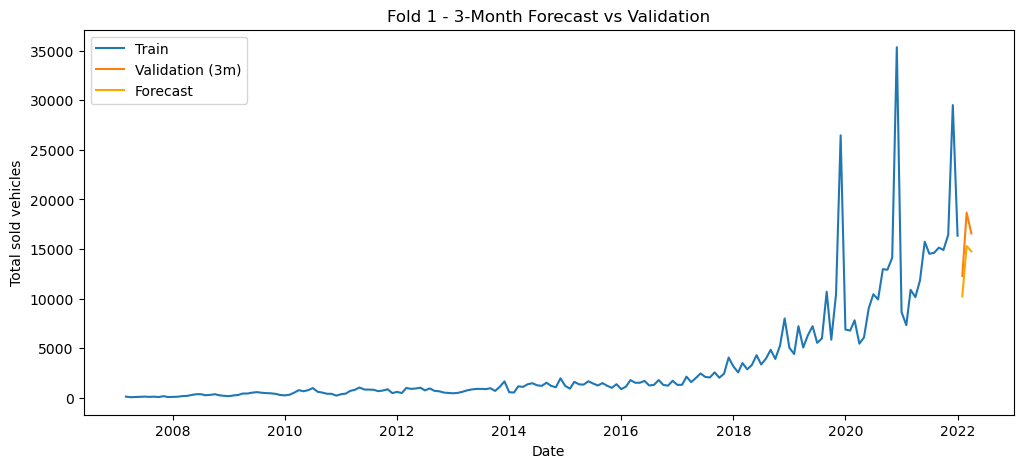


Fold 2
Train: 2007-03-01 to 2023-01-01
Validation: 2023-02-01 to 2023-04-01
RMSE: 2135.85
MAE: 1807.43
MAPE / Error margin (%): 8.95


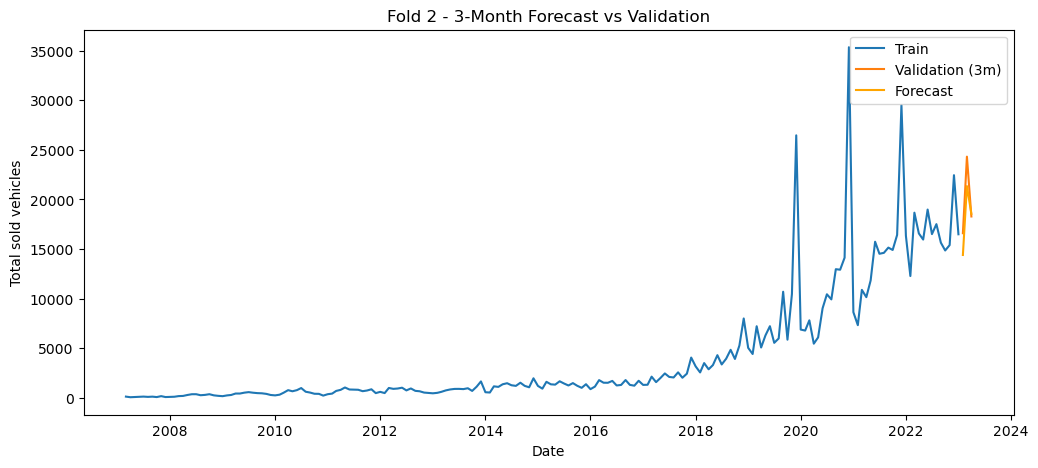


Fold 3
Train: 2007-03-01 to 2024-01-01
Validation: 2024-02-01 to 2024-04-01
RMSE: 1555.48
MAE: 1542.20
MAPE / Error margin (%): 6.10


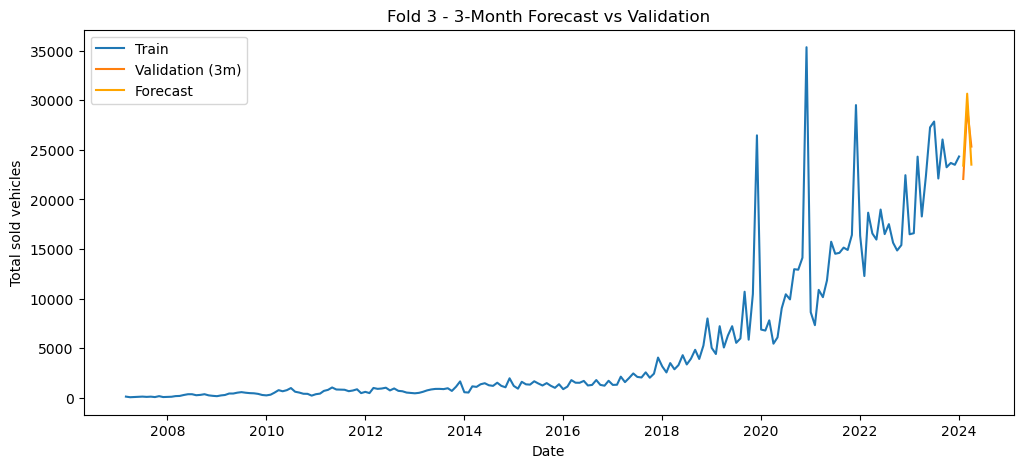


 Average performance over all folds:
Average RMSE: 2064.10
Average MAE: 1918.53
Average MAPE / Error margin (%): 10.08


In [10]:
# Load data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Target only
y = df['Totaal_verkochte_wegvoertuigen']
forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# Metrics storage
rmse_scores, mae_scores, mape_scores = [], [], []

# SARIMA parameters (example: (1,1,1)x(1,1,1,12))
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12

for i, (train_index, val_index) in enumerate(tscv.split(y)):
    y_train, y_val_full = y.iloc[train_index], y.iloc[val_index]
    y_val = y_val_full.iloc[:forecast_horizon]

    # Fit SARIMA model
    model = SARIMAX(y_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=0)

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, forecast))
    mae = mean_absolute_error(y_val, forecast)
    mape = np.mean(np.abs((y_val - forecast) / y_val)) * 100  # In percentage

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    print(f"\nFold {i+1}")
    print(f"Train: {df.iloc[train_index]['Periode'].min().date()} to {df.iloc[train_index]['Periode'].max().date()}")
    print(f"Validation: {df.iloc[val_index]['Periode'].min().date()} to {df.iloc[val_index]['Periode'].min() + pd.DateOffset(months=forecast_horizon - 1):%Y-%m-%d}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Error margin (%): {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df.iloc[train_index]['Periode'], y_train, label='Train')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], y_val, label='Validation (3m)')
    plt.plot(df.iloc[val_index]['Periode'][:forecast_horizon], forecast, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - 3-Month Forecast vs Validation')
    plt.xlabel('Date')
    plt.ylabel('Total sold vehicles')
    plt.legend()
    plt.show()

# Print averages
print("\n Average performance over all folds:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE / Error margin (%): {np.mean(mape_scores):.2f}")


#### LSTM (Long Short-Term Memory)

c:\Users\dylan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

Fold 1
RMSE: 4519.98
MAE: 4282.74
MAPE / Error margin (%): 28.57


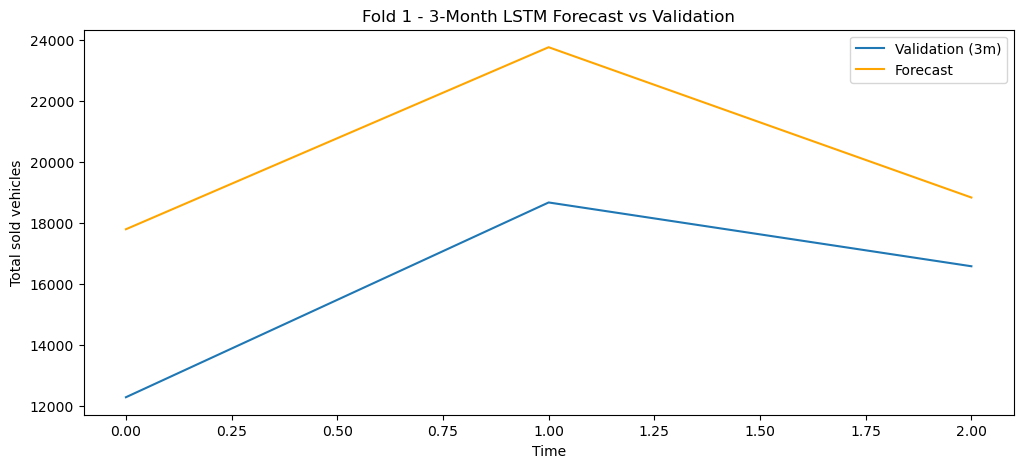

c:\Users\dylan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step

Fold 2
RMSE: 5359.22
MAE: 3875.25
MAPE / Error margin (%): 17.36


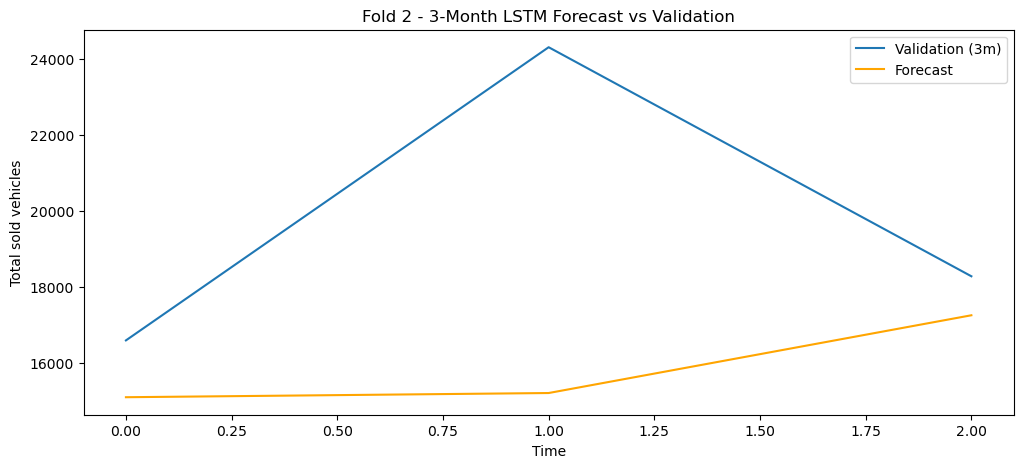

c:\Users\dylan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step

Fold 3
RMSE: 6831.92
MAE: 6070.36
MAPE / Error margin (%): 22.79


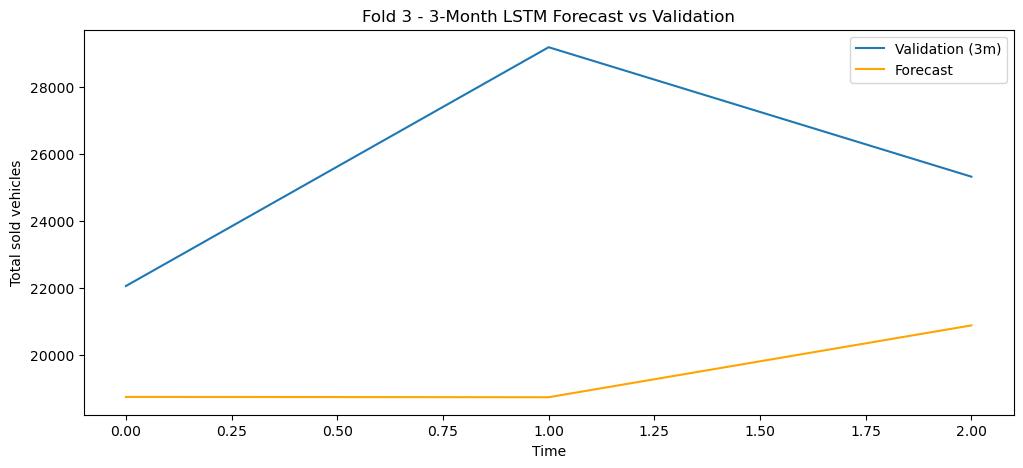


🔚 Average performance over all folds:
Average RMSE: 5570.38
Average MAE: 4742.79
Average MAPE / Error margin (%): 22.91


In [12]:
# Prepare data
df = df_lagged.copy()
df['Periode'] = pd.to_datetime(df['Periode'])
df.sort_values('Periode', inplace=True)

# Features and target
feature_cols = [col for col in df.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]
X = df[feature_cols].values
y = df['Totaal_verkochte_wegvoertuigen'].values.reshape(-1, 1)

# Scale features and target
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Reshape for LSTM: (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

forecast_horizon = 3
tscv = TimeSeriesSplit(n_splits=3, test_size=12)

rmse_scores, mae_scores, mape_scores = [], [], []

for i, (train_index, val_index) in enumerate(tscv.split(X_scaled)):
    X_train, X_val_full = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val_full = y_scaled[train_index], y_scaled[val_index]
    X_val, y_val = X_val_full[:forecast_horizon], y_val_full[:forecast_horizon]

    # Build LSTM model
    model = Sequential([
        LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Train
    model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

    # Predict
    y_pred = model.predict(X_val)
    y_pred_inv = y_scaler.inverse_transform(y_pred)
    y_val_inv = y_scaler.inverse_transform(y_val)

    # Metrics
    rmse = np.sqrt(np.mean((y_val_inv - y_pred_inv) ** 2))
    mae = np.mean(np.abs(y_val_inv - y_pred_inv))
    mape = np.mean(np.abs((y_val_inv - y_pred_inv) / y_val_inv)) * 100

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    print(f"\nFold {i+1}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE / Error margin (%): {mape:.2f}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(y_val_inv)), y_val_inv, label='Validation (3m)')
    plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Forecast', color='orange')
    plt.title(f'Fold {i+1} - 3-Month LSTM Forecast vs Validation')
    plt.xlabel('Time')
    plt.ylabel('Total sold vehicles')
    plt.legend()
    plt.show()

print("\n🔚 Average performance over all folds:")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average MAPE / Error margin (%): {np.mean(mape_scores):.2f}")


### xgboost

In [14]:

# Use the in-memory lagged DataFrame
df = df_lagged
target_column = 'Totaal_verkochte_wegvoertuigen'


# Prepare features and target
X = df.drop(columns=[target_column, 'Periode'])
y = df[target_column]

# TimeSeriesSplit configuration
tscv = TimeSeriesSplit(n_splits=5, test_size=3)

# Store results
train_mae_scores = []
test_mae_scores = []

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {i + 1}: Training model...")

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    # Define and fit XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        max_depth=3,           # Reduce depth
        learning_rate=0.05,    # Smoother learning
        subsample=0.8,         # Random rows per tree
        colsample_bytree=0.8,  # Random columns per tree
        reg_alpha=10,          # L1 regularization
        reg_lambda=1,          # L2 regularization
        random_state=42,
        eval_metric='mae'
    )
    model.fit(X_train, y_train)

    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)

    print(f"Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f}")
    print("Last 3 test predictions:")
    for actual, pred in zip(y_test.tail(3), y_test_pred[-3:]):
        print(f"  Actual: {actual:.0f}, Predicted: {pred:.0f}")

# Summary
print("\n--- Cross-Validation Summary ---")
print(f"Average Train MAE: {sum(train_mae_scores) / len(train_mae_scores):.2f}")
print(f"Average Test MAE:  {sum(test_mae_scores) / len(test_mae_scores):.2f}")





Fold 1: Training model...
Train MAE: 74.25 | Test MAE: 1883.12
Last 3 test predictions:
  Actual: 23676, Predicted: 22742
  Actual: 23490, Predicted: 22723
  Actual: 24325, Predicted: 20377

Fold 2: Training model...
Train MAE: 80.55 | Test MAE: 6524.10
Last 3 test predictions:
  Actual: 22060, Predicted: 20218
  Actual: 29193, Predicted: 18947
  Actual: 25326, Predicted: 17841

Fold 3: Training model...
Train MAE: 84.93 | Test MAE: 3935.70
Last 3 test predictions:
  Actual: 26607, Predicted: 20200
  Actual: 27731, Predicted: 25340
  Actual: 25370, Predicted: 22361

Fold 4: Training model...
Train MAE: 84.56 | Test MAE: 4485.42
Last 3 test predictions:
  Actual: 23683, Predicted: 23393
  Actual: 28820, Predicted: 25433
  Actual: 30491, Predicted: 20712

Fold 5: Training model...
Train MAE: 90.63 | Test MAE: 11416.28
Last 3 test predictions:
  Actual: 32623, Predicted: 25401
  Actual: 39594, Predicted: 23236
  Actual: 33680, Predicted: 23011

--- Cross-Validation Summary ---
Average Tr